# Laporan Proyek Machine Learning - Sistem Rekomendasi Film

## Project Overview

Industri streaming digital menghadapi tantangan "information overload" dengan jutaan konten film yang tersedia. Pengguna kesulitan menemukan film yang sesuai preferensi mereka, sehingga sistem rekomendasi menjadi solusi penting untuk:

- Meningkatkan user experience dan engagement
- Membantu discovery konten yang relevan
- Meningkatkan retention rate platform
- Memberikan personalisasi pengalaman menonton

Proyek ini mengimplementasikan sistem rekomendasi film menggunakan dua pendekatan machine learning: **Content-Based Filtering** dan **Collaborative Filtering**.

## Business Understanding

### Problem Statements

1. **Bagaimana memberikan rekomendasi film berdasarkan karakteristik dan metadata film?**
   - Memanfaatkan informasi genre, aktor, sutradara, kata kunci, dan overview film
   - Mengidentifikasi kemiripan antar film berdasarkan konten

2. **Bagaimana memberikan rekomendasi berdasarkan pola preferensi pengguna serupa?**
   - Menganalisis pola rating pengguna dengan selera serupa
   - Memprediksi rating untuk film yang belum ditonton

### Goals

1. **Content-Based Filtering**: Mengembangkan sistem rekomendasi berbasis metadata film dengan target NDCG@10 ≥ 0.5 untuk menunjukkan kualitas ranking yang baik
2. **Collaborative Filtering**: Mengembangkan sistem prediksi rating dengan target RMSE ≤ 1.0 dan MAE ≤ 0.8

### Solution Statements

1. **Content-Based Filtering**: TF-IDF Vectorization + Cosine Similarity untuk analisis metadata
2. **Collaborative Filtering**: SVD (Singular Value Decomposition) untuk matrix factorization

## Data Understanding

Proyek ini menggunakan **The Movies Dataset** yang tersedia di Kaggle, yang merupakan kompilasi data film dari The Movie Database (TMDb) dan rating dari MovieLens. Dataset ini dipilih karena menyediakan data yang komprehensif untuk kedua pendekatan sistem rekomendasi.

**Sumber Dataset**: [The Movies Dataset - Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset)

**Karakteristik Dataset**:
- **Total film**: 45,000+ film metadata
- **Rating data**: 26 juta rating dari 270,000 pengguna
- **Periode data**: Film dari tahun 1900-2017
- **Format data**: CSV files dengan struktur relasional

Dataset terdiri dari 5 file utama dengan variabel sebagai berikut:

**1. movies_metadata.csv (45,466 baris)**
- `id`: ID unik film di TMDb (integer)
- `title`: Judul film (string)
- `overview`: Sinopsis/ringkasan plot film (text)
- `genres`: Genre film dalam format JSON (string)
- `release_date`: Tanggal rilis film (date)
- `runtime`: Durasi film dalam menit (integer)
- `vote_average`: Rating rata-rata (float, skala 1-10)
- `vote_count`: Jumlah vote yang diterima (integer)
- `budget`: Budget produksi film dalam USD (integer)
- `revenue`: Pendapatan film dalam USD (integer)
- `original_language`: Bahasa asli film (string)
- `popularity`: Skor popularitas film (float)

**2. credits.csv (45,476 baris)**
- `id`: ID film untuk merging dengan metadata (integer)
- `cast`: Informasi pemain dalam format JSON array (string)
- `crew`: Informasi kru produksi dalam format JSON array (string)

**3. keywords.csv (46,419 baris)**
- `id`: ID film (integer)
- `keywords`: Kata kunci terkait film dalam format JSON array (string)

**4. ratings_small.csv (100,004 baris)**
- `userId`: ID unik pengguna (integer)
- `movieId`: ID film dalam sistem MovieLens (integer)
- `rating`: Rating yang diberikan pengguna (float, skala 0.5-5.0)
- `timestamp`: Waktu pemberian rating dalam Unix timestamp (integer)

**5. links_small.csv (9,125 baris)**
- `movieId`: MovieLens ID (integer)
- `imdbId`: IMDb ID untuk linking eksternal (integer)
- `tmdbId`: TMDb ID untuk menghubungkan dengan metadata (integer)

### Import Library

Mengimpor semua library yang diperlukan untuk:
- Data manipulation dan analisis (pandas, numpy)
- Visualisasi data (matplotlib, seaborn)
- Text processing dan feature extraction (sklearn)
- Sistem rekomendasi (surprise library)
- Parsing data JSON (ast)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from ast import literal_eval

from sklearn.metrics import ndcg_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn._oldcore')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='matplotlib.colors')

### Load Data

Memuat dataset dari Kaggle yang terdiri dari 5 file utama:
- movies_metadata.csv: Metadata film lengkap
- credits.csv: Informasi cast dan crew
- keywords.csv: Kata kunci film
- ratings_small.csv: Data rating pengguna
- links_small.csv: Mapping antar ID sistem

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_path = '/kaggle/input/the-movies-dataset/'
movies = pd.read_csv(data_path + 'movies_metadata.csv', low_memory=False)
credits = pd.read_csv(data_path +'credits.csv')
keywords = pd.read_csv(data_path +'keywords.csv')
ratings = pd.read_csv(data_path +'ratings_small.csv')
links_small = pd.read_csv(data_path + 'links_small.csv')

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


### Check Missing and Duplicated Values

Melakukan data quality assessment untuk:
- Mengidentifikasi missing values di setiap dataset
- Mendeteksi duplicate rows
- Memahami struktur dan kualitas data
- Merencanakan strategi data cleaning

In [3]:
datasets = {
    'Movies Metadata': movies,
    'Credits': credits,
    'Keywords': keywords,
    'Ratings (Small)': ratings,
    'Links (Small)': links_small
}

for name, df in datasets.items():
    print(f"{name} Info")
    print(df.info())
    print(f"\nMissing Values in {name}")
    print(df.isna().sum())
    print(f"\nDuplicate Rows in {name}")
    print(f"Number of duplicates: {df.duplicated().sum()}")
    print("\n" + "="*40 + "\n")

Movies Metadata Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-

### Univariate EDA

Analisis distribusi variabel tunggal untuk memahami:
- Distribusi genre film (untuk content-based filtering)
- Pola rating pengguna (untuk collaborative filtering)
- Karakteristik dasar dataset

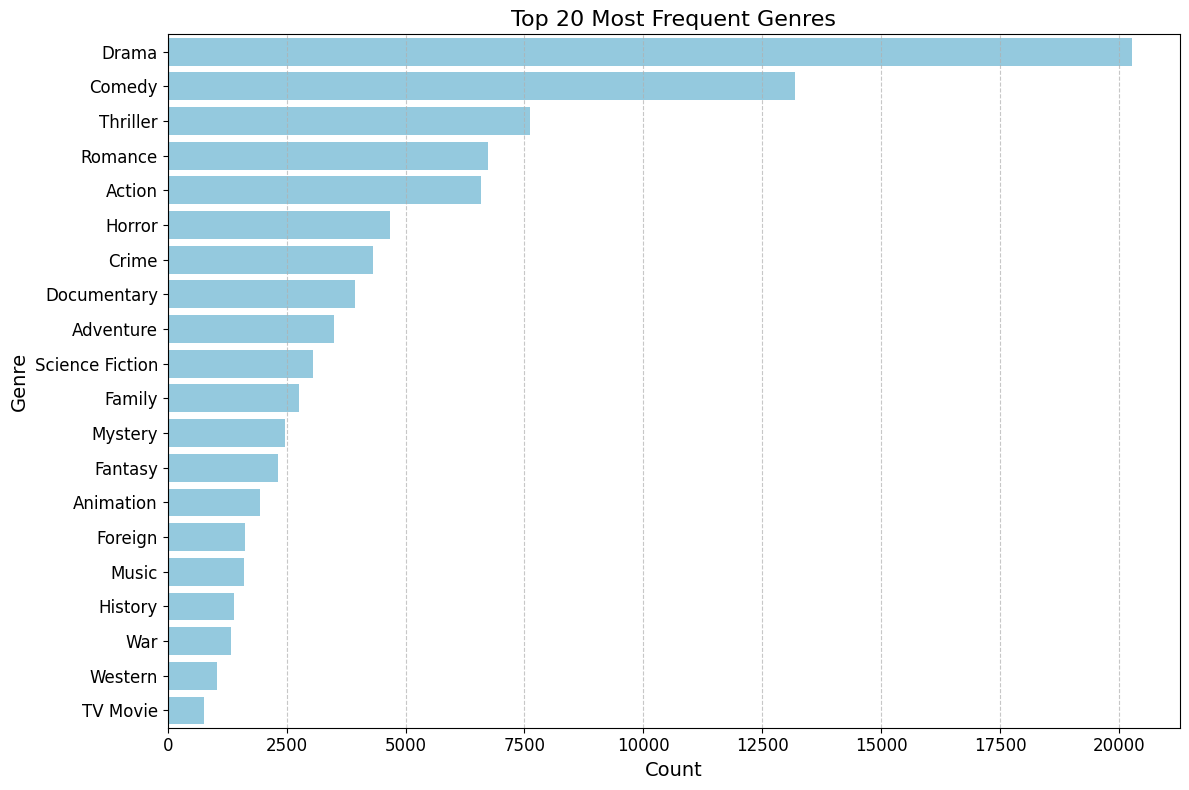


Insight yang diharapkan:
Genre terpopuler: Drama, Comedy, Thriller


In [4]:
def extract_genres(genre_str):
    try:
        # Pastikan genre_str bukan float (NaN) atau None sebelum evaluasi
        if pd.isna(genre_str) or not isinstance(genre_str, str):
            return []
        genres_list = ast.literal_eval(genre_str)
        return [g['name'] for g in genres_list if isinstance(g, dict) and 'name' in g]
    except (ValueError, SyntaxError):
        # Jika ada string yang tidak valid, kembalikan list kosong
        return []

movies_copy = movies.copy()
movies_copy['genre_list'] = movies_copy['genres'].apply(extract_genres)

all_genres = sum(movies_copy['genre_list'].tolist(), [])

plt.figure(figsize=(12, 8)) 
genre_counts_for_order = pd.Series(all_genres).value_counts()
top_20_genres_order = genre_counts_for_order.head(20).index

sns.countplot(y=all_genres, order=top_20_genres_order, color='skyblue')
plt.title("Top 20 Most Frequent Genres", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

print("\nInsight yang diharapkan:")
if not genre_counts_for_order.empty:
    print(f"Genre terpopuler: {genre_counts_for_order.index[0]}, {genre_counts_for_order.index[1]}, {genre_counts_for_order.index[2]}")
else:
    print("Tidak ada genre yang ditemukan untuk ditampilkan.")

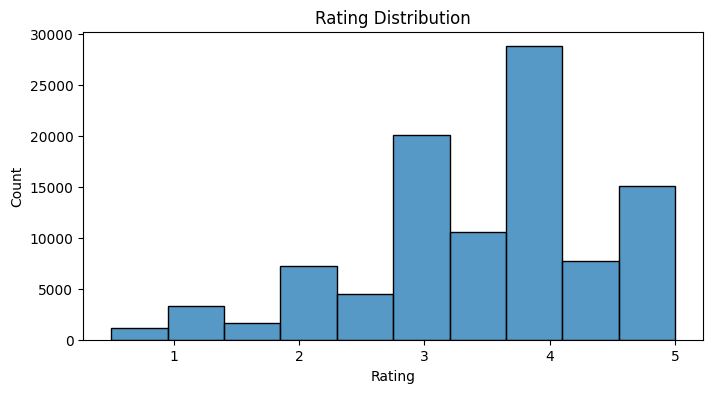

Insight: Rating 4.0 paling banyak diberikan (28750 ratings)
Rating rata-rata: 3.54


In [5]:
# Distribusi rating (relevan untuk collaborative filtering)
plt.figure(figsize=(8,4))
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(f"Insight: Rating 4.0 paling banyak diberikan ({ratings[ratings['rating']==4.0].shape[0]} ratings)")
print(f"Rating rata-rata: {ratings['rating'].mean():.2f}")

### Multivariate EDA

Analisis hubungan antar variabel untuk:
- User activity patterns (jumlah rating per user)
- Movie popularity patterns (jumlah rating per film)
- Korelasi fitur numerik film
- Relationship antara kualitas dan popularitas film

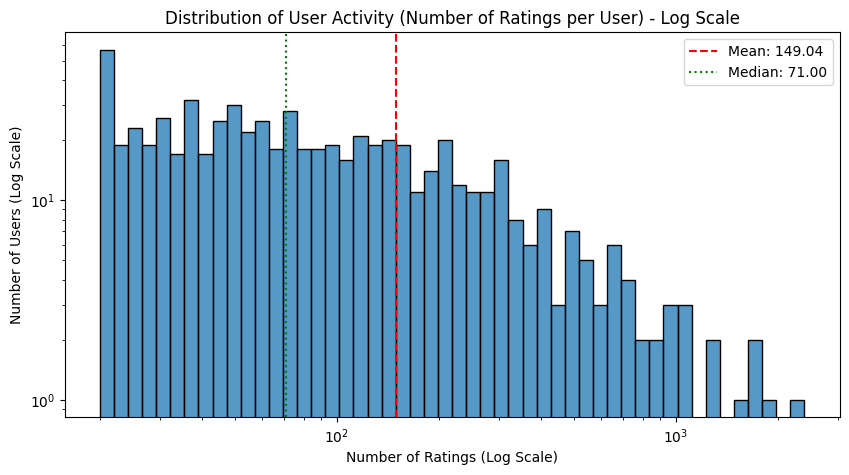

In [6]:
# 3. Jumlah rating per user (aktivitas user)
user_rating_counts = ratings['userId'].value_counts()
mean_ratings = user_rating_counts.mean()
median_ratings = user_rating_counts.median()

plt.figure(figsize=(10,5))
sns.histplot(user_rating_counts, bins=50, log_scale=(True, True))
plt.axvline(mean_ratings, color='red', linestyle='--', label=f'Mean: {mean_ratings:.2f}')
plt.axvline(median_ratings, color='green', linestyle=':', label=f'Median: {median_ratings:.2f}')
plt.legend()
plt.title("Distribution of User Activity (Number of Ratings per User) - Log Scale")
plt.xlabel("Number of Ratings (Log Scale)")
plt.ylabel("Number of Users (Log Scale)")
plt.show()

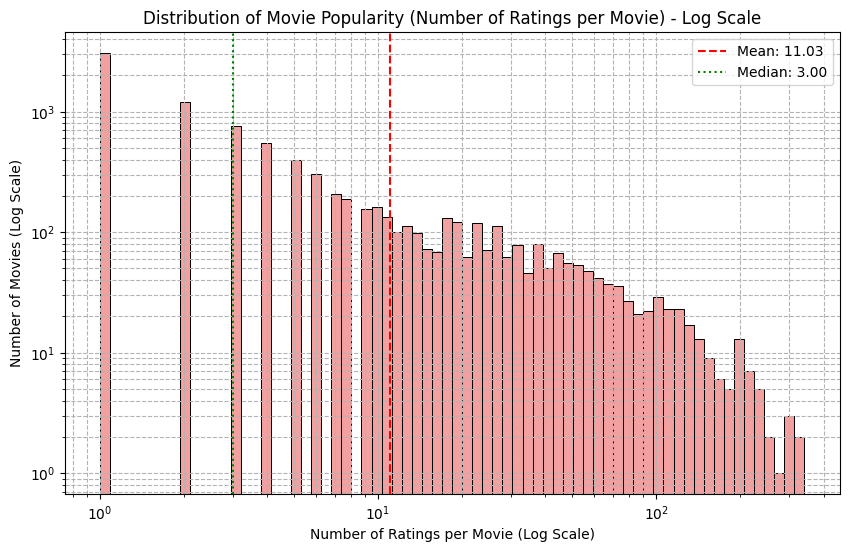

In [7]:
# 4. Jumlah rating per movie (popularitas film)
movie_rating_counts = ratings['movieId'].value_counts()
mean_ratings_per_movie = movie_rating_counts.mean()
median_ratings_per_movie = movie_rating_counts.median()

plt.figure(figsize=(10,6)) # Slightly increased figure height
sns.histplot(movie_rating_counts, bins=70, log_scale=(True, True), color='lightcoral')
plt.axvline(mean_ratings_per_movie, color='red', linestyle='--', label=f'Mean: {mean_ratings_per_movie:.2f}')
plt.axvline(median_ratings_per_movie, color='green', linestyle=':', label=f'Median: {median_ratings_per_movie:.2f}')
plt.legend()
plt.title("Distribution of Movie Popularity (Number of Ratings per Movie) - Log Scale")
plt.xlabel("Number of Ratings per Movie (Log Scale)")
plt.ylabel("Number of Movies (Log Scale)")
plt.grid(True, which="both", ls="--", c='0.7') # Add a grid
plt.show()


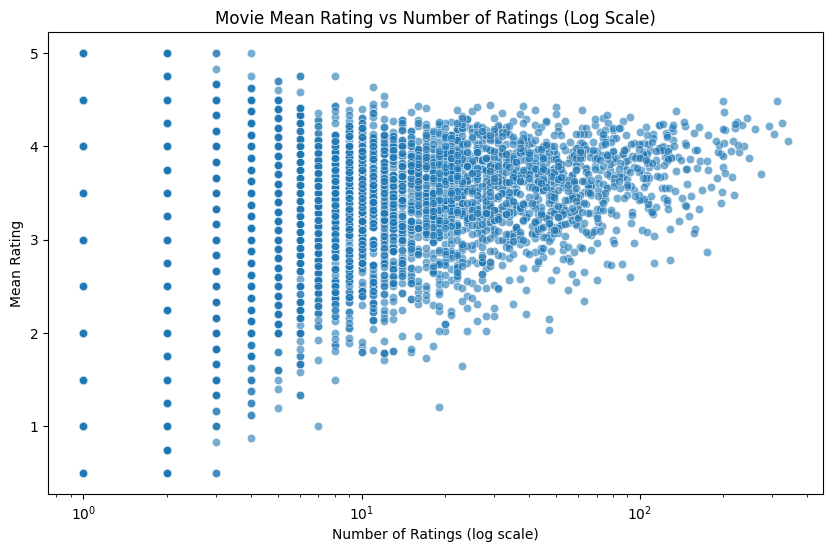

In [8]:
# 5 Rata-rata rating per film vs jumlah rating (popularitas & kualitas)
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['mean_rating', 'num_ratings']
movie_stats = movie_stats.reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(data=movie_stats, x='num_ratings', y='mean_rating', alpha=0.6)
plt.xscale('log')
plt.title("Movie Mean Rating vs Number of Ratings (Log Scale)")
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Mean Rating")
plt.show()

Film dengan rating tinggi (>4.0) umumnya memiliki jumlah rating yang cukup
Ini menunjukkan korelasi antara kualitas dan popularitas film

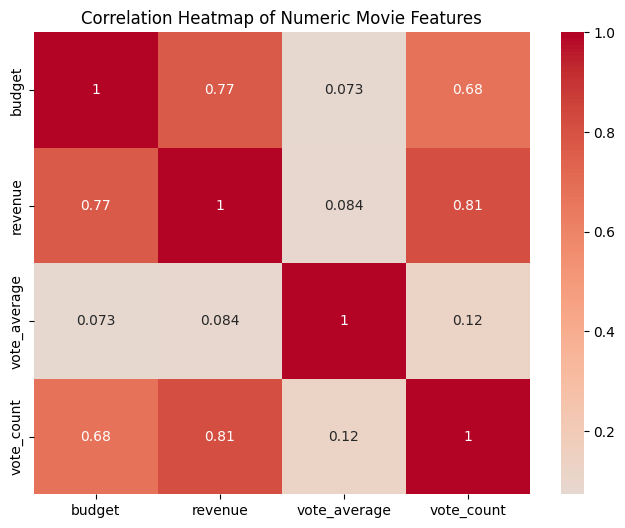

In [9]:
# 6. Heatmap korelasi fitur numerik di movies (misal budget, revenue, vote_average)
num_cols = ['budget', 'revenue', 'vote_average', 'vote_count']
movies_num = movies[num_cols].copy()

# Ubah tipe ke numerik, errors='coerce' untuk non-numeric -> NaN
for col in num_cols:
    movies_num[col] = pd.to_numeric(movies_num[col], errors='coerce')

plt.figure(figsize=(8,6))
sns.heatmap(movies_num.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numeric Movie Features")
plt.show()

* **Budget & Revenue**: Memiliki korelasi sangat tinggi (0.77), menunjukkan bahwa film dengan anggaran besar cenderung menghasilkan pendapatan yang tinggi.
* **Jumlah Suara (Vote Count) & Finansial**: `vote_count` berkorelasi kuat dengan Revenue (0.81) dan cukup kuat dengan Budget (0.68), menyiratkan film populer seringkali memiliki anggaran dan pendapatan tinggi.
* **Rata-rata Rating (Vote Average) & Finansial**: Korelasi sangat rendah dengan Budget (0.073) dan Revenue (0.083). Artinya, kesuksesan finansial atau biaya produksi film tidak menjamin kualitasnya di mata penonton.
* **Rata-rata Rating (Vote Average) & Jumlah Suara (Vote Count)**: Korelasi positif yang lemah (0.12), menunjukkan bahwa film yang lebih banyak divote cenderung sedikit memiliki rating rata-rata yang lebih tinggi, namun hubungannya tidak kuat.

## Data Preparation

Tahapan data preparation untuk kedua algoritma sistem rekomendasi:

**Teknik yang Digunakan:**

1. **Data Cleaning & Type Conversion**
   - Konversi kolom ID ke numerik untuk merging dataset
   - Handling missing values
   - **Alasan:** Memastikan konsistensi data untuk proses merging

2. **Data Integration** 
   - Menggabungkan movies_metadata, credits, dan keywords
   - **Alasan:** Content-based filtering membutuhkan informasi lengkap dari berbagai sumber

3. **Feature Extraction**
   - Ekstraksi data JSON (genres, cast, crew, keywords) 
   - Pembuatan "soup" dengan menggabungkan fitur teks
   - **Alasan:** Mengubah data semi-structured menjadi format yang dapat diproses algoritma ML

4. **Text Preprocessing**
   - Menghilangkan spasi dalam nama untuk konsistensi tokenisasi
   - **Alasan:** Meningkatkan akurasi perhitungan similarity

5. **Data Loading untuk Surprise Library**
   - Format data rating sesuai library Surprise
   - **Alasan:** Library Surprise memerlukan format khusus untuk collaborative filtering

### Data Preparation Keseluruhan

Fungsi-fungsi untuk membersihkan setiap dataset:
- Handle missing values dengan strategi yang tepat
- Remove duplicate data
- Convert data types sesuai kebutuhan
- Prepare data untuk modeling phase

In [10]:
def prepare_movies_metadata(df):
    # Hapus duplikat 
    df = df.drop_duplicates()

    # Drop kolom tidak perlu
    cols_drop = ['belongs_to_collection', 'homepage', 'tagline']
    df = df.drop(columns=cols_drop)

    # Isi missing value
    df['overview'] = df['overview'].fillna('')
    df['poster_path'] = df['poster_path'].fillna('')
    df['release_date'] = df['release_date'].fillna(df['release_date'].mode()[0])
    df['runtime'] = df['runtime'].fillna(df['runtime'].median())
    df['status'] = df['status'].fillna(df['status'].mode()[0])
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].median())
    df['vote_count'] = df['vote_count'].fillna(df['vote_count'].median())
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce').fillna(0)
    
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
    median_popularity = df['popularity'].median()
    df['popularity'] = df['popularity'].fillna(median_popularity)
    
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    
    return df


def prepare_credits(df):
    # Hapus duplikat
    df = df.drop_duplicates()
    # Tidak ada missing values
    return df


def prepare_keywords(df):
    # Hapus duplikat
    df = df.drop_duplicates()
    # Tidak ada missing values
    return df


def prepare_links_small(df):
    # Isi missing tmdbId dengan modus (nilai paling sering muncul)
    if df['tmdbId'].isna().sum() > 0:
        mode_tmdb = df['tmdbId'].mode()[0]
        df['tmdbId'] = df['tmdbId'].fillna(mode_tmdb)
    return df


def prepare_ratings_small(df):
    # Tidak ada missing atau duplikat, tapi pastikan duplikat kalau ada tetap dihapus
    df = df.drop_duplicates()
    return df


# Terapkan fungsi ke masing-masing dataset
movies = prepare_movies_metadata(movies)
credits = prepare_credits(credits)
keywords = prepare_keywords(keywords)
links = prepare_links_small(links_small)
ratings = prepare_ratings_small(ratings)

print("Movies Metadata missing values:\n", movies.isna().sum())
print("\nCredits missing values:\n", credits.isna().sum())
print("\nKeywords missing values:\n", keywords.isna().sum())
print("\nLinks Small missing values:\n", links.isna().sum())
print("\nRatings Small missing values:\n", ratings.isna().sum())

Movies Metadata missing values:
 adult                    0
budget                   0
genres                   0
id                       0
imdb_id                 17
original_language       11
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     3
production_countries     3
release_date             3
revenue                  6
runtime                  0
spoken_languages         6
status                   0
title                    6
video                    6
vote_average             0
vote_count               0
dtype: int64

Credits missing values:
 cast    0
crew    0
id      0
dtype: int64

Keywords missing values:
 id          0
keywords    0
dtype: int64

Links Small missing values:
 movieId    0
imdbId     0
tmdbId     0
dtype: int64

Ratings Small missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


### Data Preparation untuk Content-Based Filtering

Mempersiapkan data khusus untuk content-based filtering:
- Merge multiple datasets berdasarkan film ID
- Ensure data consistency untuk feature extraction
- Create unified dataset dengan metadata lengkap

In [11]:
# Ubah kolom 'id' di movies ke numerik
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')

# Hapus baris yang tidak punya 'id' atau 'title'
movies_clean = movies.dropna(subset=['id', 'title']).copy()

# Ubah 'id' jadi integer
movies_clean['id'] = movies_clean['id'].astype(int)

# Pastikan 'id' di credits dan keywords juga integer
credits = credits.dropna(subset=['id']).copy()
keywords = keywords.dropna(subset=['id']).copy()
credits['id'] = pd.to_numeric(credits['id'], errors='coerce').astype(int)
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce').astype(int)

# Gabungkan semua data
movies = movies_clean.merge(credits, on='id', how='inner')
movies = movies.merge(keywords, on='id', how='inner')

#### Feature Extraction dan Soup Creation

Ekstraksi fitur dari data JSON dan pembuatan text representation:
- Parse JSON data (cast, crew, genres, keywords)
- Extract top 3 actors dan director
- Combine semua fitur menjadi "soup" untuk vectorization
- Clean dan normalize text data

In [12]:
def extract_names(obj, key_filter=None, top_n=None):
    try:
        items = ast.literal_eval(obj)
        if key_filter:  # Misalnya untuk 'Director' pada crew
            items = [i for i in items if key_filter(i)]
        if top_n:
            items = items[:top_n]
        return [i['name'].replace(" ", "") for i in items]
    except:
        return []

# Gunakan fungsi ini untuk setiap kolom:
movies['cast'] = movies['cast'].apply(lambda x: extract_names(x, top_n=3))
movies['crew'] = movies['crew'].apply(lambda x: extract_names(x, key_filter=lambda d: d.get('job') == 'Director'))
movies['keywords'] = movies['keywords'].apply(lambda x: extract_names(x))
movies['genres'] = movies['genres'].apply(lambda x: extract_names(x))

# Buat soup
def create_soup(x):
    return ' '.join(x['cast']) + ' ' + ' '.join(x['crew']) + ' ' + \
           ' '.join(x['keywords']) + ' ' + ' '.join(x['genres']) + ' ' + x['overview']
    
movies['soup'] = movies.apply(create_soup, axis=1)

#### Text Vectorization dan Similarity Calculation

Konversi text ke numerical representation:
- TF-IDF vectorization untuk capture term importance
- Cosine similarity calculation antar film
- Create index mapping untuk efficient lookup
- Prepare similarity matrix untuk recommendation

In [13]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['soup'])

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Index mapping (judul -> index)
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

### Data Preparation untuk Collaborative Filtering

Mempersiapkan data rating untuk matrix factorization:
- Format data sesuai Surprise library requirements
- Define rating scale (0.5-5.0)
- Create user-item interaction matrix
- Prepare untuk SVD algorithm training

In [14]:
# Load ke dalam Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

## Modeling

Tahap modeling mengimplementasikan dua algoritma sistem rekomendasi yang berbeda untuk menyelesaikan problem statements. Kedua model dirancang untuk menghasilkan **Top-N Recommendations** sebagai output yang dapat langsung digunakan oleh sistem.

### 1. Content-Based Filtering

**Algoritma**: TF-IDF Vectorization + Cosine Similarity

**Cara Kerja:**
1. Ekstraksi fitur dari metadata film (genres, cast, crew, keywords, overview)
2. Menggabungkan fitur menjadi "soup" text representation
3. TF-IDF vectorization untuk capture term importance
4. Menghitung cosine similarity antar film
5. Recommend film dengan similarity tertinggi

**Kelebihan:**
- Tidak ada cold start problem untuk item baru
- Rekomendasi mudah dijelaskan (berdasarkan fitur)
- Dapat handle item dengan metadata lengkap

**Kekurangan:**
- Terbatas pada kualitas metadata
- Cenderung over-specialization
- Tidak capture complex user preferences

In [15]:
def get_recommendations_df(title, cosine_sim=cosine_sim, top_n=10):
    try:
        idx = indices[title]
    except KeyError:
        return pd.DataFrame()  # Bisa juga return message tapi biar konsisten pakai df kosong

    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]
    elif isinstance(idx, (list, np.ndarray)):
        idx = idx[0]
    
    idx = int(idx)

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in sim_scores]
    similarity_scores = [round(i[1], 3) for i in sim_scores]

    titles = movies.iloc[movie_indices]['title'].values

    df = pd.DataFrame({
        'Title': titles,
        'Cosine Similarity': similarity_scores
    })
    return df

### 2. Collaborative Filtering

**Algoritma**: Singular Value Decomposition (SVD)

**Cara Kerja:**
1. Build user-item rating matrix dari historical data
2. Apply SVD untuk matrix factorization
3. Predict rating untuk film yang belum ditonton
4. Rank film berdasarkan predicted rating
5. Recommend top-N films dengan highest predicted ratings

**Kelebihan:**
- Capture complex user-item interaction patterns
- Rekomendasi lebih diverse dan unexpected
- Tidak memerlukan metadata film
- Discover hidden preferences dan relationships

**Kekurangan:**
- Cold start problem untuk user/item baru
- Membutuhkan sufficient rating data
- Less interpretable recommendations
- Higher computational requirements

In [16]:
# Train SVD
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# Fit full data
trainset = data.build_full_trainset()
svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9084  0.8996  0.9067  0.9049  0.0038  
MAE (testset)     0.6991  0.6933  0.6999  0.6974  0.0029  
Fit time          0.80    0.83    0.79    0.80    0.02    
Test time         0.15    0.31    0.14    0.20    0.08    


In [17]:
# Ambil mapping TMDB <-> MovieLens
movie_id_map = links_small.set_index('movieId')['tmdbId'].to_dict()

def recommend_movies_collab_df(user_id, n=10):
    movie_ids = ratings['movieId'].unique()
    predictions = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in movie_ids]
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [pred[0] for pred in predictions[:n]]

    data = []

    for mid in top_movie_ids:
        tmdb_id = movie_id_map.get(mid)
        if tmdb_id in movies['id'].values:
            movie_row = movies[movies['id'] == tmdb_id].iloc[0]
            title = movie_row['title']
            genres = ', '.join(movie_row['genres']) if isinstance(movie_row['genres'], list) else movie_row['genres']
            predicted_rating = round(svd.predict(user_id, mid).est, 2)
            data.append({'Title': title, 'Genres': genres, 'Predicted Rating': predicted_rating})

    df = pd.DataFrame(data)
    return df

### Testing Kedua Model

Testing functionality dan output quality dari kedua sistem:
- Content-based: Test dengan film "Spirited Away"
- Collaborative: Test dengan User ID 1
- Display user preferences dan recommended movies
- Verify output format dan quality

In [18]:
# Testing Content-Based Filtering
print("=== CONTENT-BASED FILTERING TEST ===")
content_based_film_title = "Spirited Away"
content_result = get_recommendations_df(content_based_film_title, top_n=10)
print(f"Rekomendasi untuk {content_based_film_title}:")
print(content_result)

# Testing Collaborative Filtering
print("\n=== COLLABORATIVE FILTERING TEST ===")
user_id = 1

# Tampilkan preferensi user
user_prefs = ratings[ratings['userId'] == user_id].merge(
    movies_clean[['id', 'title']], 
    left_on='movieId', right_on='id', how='left'
)[['title', 'rating']].sort_values('rating', ascending=False).head(5)

print(f"User {user_id} preferences (top rated films):")
print(user_prefs)

# Tampilkan rekomendasi
collab_result = recommend_movies_collab_df(user_id, n=10)
print(f"\nRekomendasi untuk User {user_id}:")
print(collab_result)

=== CONTENT-BASED FILTERING TEST ===
Rekomendasi untuk Spirited Away:
                            Title  Cosine Similarity
0           Mei and the Kittenbus              0.135
1                           North              0.133
2                          Shower              0.133
3              Hotarubi no Mori e              0.130
4              My Neighbor Totoro              0.129
5  Mr. Dough and the Egg Princess              0.119
6            Howl's Moving Castle              0.118
7       Sabrina the Teenage Witch              0.118
8                 Berta's Motives              0.117
9         Kiki's Delivery Service              0.117

=== COLLABORATIVE FILTERING TEST ===
User 1 preferences (top rated films):
           title  rating
12           NaN     4.0
13  American Pie     4.0
4            NaN     4.0
8            NaN     3.5
19           NaN     3.0

Rekomendasi untuk User 1:
                 Title                     Genres  Predicted Rating
0    The African Queen    

## Evaluation

### Evaluasi Model Content-Based Filtering 

**Metrik:** Precision@K, Recall@K, F1@K, dan NDCG@K

**Formula Precision@K:**
$$\text{Precision@K} = \frac{\text{Relevant Items in Top-K}}{\text{K}}$$

**Formula Recall@K:**
$$\text{Recall@K} = \frac{\text{Relevant Items in Top-K}}{\text{Total Relevant Items}}$$

**Formula F1@K:**
$$\text{F1@K} = \frac{2 \times \text{Precision@K} \times \text{Recall@K}}{\text{Precision@K} + \text{Recall@K}}$$

**Formula NDCG@K:**
$$\text{NDCG@K} = \frac{\text{DCG@K}}{\text{IDCG@K}}$$

**Cara Kerja:** 
- **Precision@K**: Mengukur proporsi item relevan dalam top-K rekomendasi
- **Recall@K**: Mengukur seberapa baik sistem menemukan semua item relevan
- **F1@K**: Harmonic mean dari precision dan recall untuk balanced assessment
- **NDCG@K**: Mengukur kualitas ranking dengan mempertimbangkan posisi item relevan

**Evaluation Functions untuk Content-Based Filtering**

- Precision@K: Proporsi relevant items dalam top-K
- Recall@K: Coverage dari total relevant items
- F1@K: Harmonic mean dari precision dan recall
- NDCG@K: Ranking quality dengan position consideration

In [19]:
def precision_at_k(predicted, ground_truth, k=10):
    predicted = predicted[:k]
    return len(set(predicted) & set(ground_truth)) / k if k > 0 else 0

def recall_at_k(predicted, ground_truth, k=10):
    if not ground_truth:
        return 0
    predicted = predicted[:k]
    return len(set(predicted) & set(ground_truth)) / len(ground_truth)

def f1_at_k(prec, rec):
    return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

def ndcg_at_k(predicted, ground_truth, k=10):
    predicted = predicted[:k]
    relevance = [1 if movie in ground_truth else 0 for movie in predicted]
    if sum(relevance) == 0:
        return 0
    return ndcg_score([sorted(relevance, reverse=True)], [relevance])

def get_predicted_dict(queries, top_n=10):
    predicted = {}
    for title in queries:
        df = get_recommendations_df(title, top_n=top_n)
        predicted[title] = df['Title'].tolist() if not df.empty else []
    return predicted

def evaluate_all(ground_truth_dict, predicted_dict, k=10):
    total_prec, total_rec, total_f1, total_ndcg, n = 0, 0, 0, 0, 0

    for title in ground_truth_dict:
        if title not in predicted_dict:
            continue
        gt = ground_truth_dict[title]
        pred = predicted_dict[title]

        prec = precision_at_k(pred, gt, k)
        rec = recall_at_k(pred, gt, k)
        f1 = f1_at_k(prec, rec)
        ndcg = ndcg_at_k(pred, gt, k)

        total_prec += prec
        total_rec += rec
        total_f1 += f1
        total_ndcg += ndcg
        n += 1

    if n == 0:
        return {"Precision@K": 0, "Recall@K": 0, "F1@K": 0, "NDCG@K": 0}

    return {
        "Precision@K": round(total_prec / n, 3),
        "Recall@K": round(total_rec / n, 3),
        "F1@K": round(total_f1 / n, 3),
        "NDCG@K": round(total_ndcg / n, 3)
    }

### Ground Truth Definition & Evaluasi Model Content-Based Filtering

Definisi ground truth berdasarkan domain expertise:
- Manually curated relevant movies untuk popular films
- Based on genres, cast, crew, keywords, overview similarity
- Include sequels, same director/actor films, similar themes
- Comprehensive coverage untuk evaluation accuracy

In [20]:
ground_truth = {
    "The Dark Knight": [
        "The Dark Knight Rises",   # Sangat Relevan: Sekuel langsung. Cast (Christian Bale, Michael Caine), Crew (Christopher Nolan, David S. Goyer), Genres (Action, Crime, Drama, Thriller), Keywords (Batman, Joker, Gotham City), Overview (melanjutkan cerita).
        "Batman Begins",           # Sangat Relevan: Prekuel langsung. Cast (Christian Bale, Michael Caine), Crew (Christopher Nolan, David S. Goyer), Genres (Action, Crime, Drama, Thriller), Keywords (Batman, origins, Gotham City), Overview (awal mula kisah).
        "Inception",               # Sangat Relevan: Crew (Christopher Nolan, Hans Zimmer), Genres (Action, Sci-Fi, Thriller), Keywords (dream, heist, mind-bending), Overview (plot kompleks, skala besar, mirip gaya Nolan).
        "Joker",                   # Relevan Kuat: Keywords (Joker, villain, psychological), Genres (Crime, Drama, Thriller), Overview (karakter gelap, tone realistis, meskipun beda crew utama dengan TDK).
        "Man of Steel",            # Relevan: Crew (Christopher Nolan sebagai produser, David S. Goyer sebagai penulis), Genres (Action, Adventure, Sci-Fi), Keywords (superhero, alien), Overview (film DC dengan tone lebih gelap).
        "The Prestige",            # Relevan: Crew (Christopher Nolan, Christian Bale), Genres (Drama, Mystery, Sci-Fi), Keywords (magic, rivalry, illusion), Overview (plot kompleks, twist, gaya Nolan).
        "Dunkirk"                  # Cukup Relevan: Crew (Christopher Nolan, Hans Zimmer), Genres (War, Drama, History), Overview (skala besar, narasi non-linear, intensitas khas Nolan, meskipun genre sangat berbeda).
    ],
    "Toy Story": [
        "Toy Story 2",             # Sangat Relevan: Sekuel langsung. Cast (Tom Hanks, Tim Allen), Crew (John Lasseter, Andrew Stanton), Genres (Animation, Adventure, Comedy, Family), Keywords (toys, friendship), Overview (melanjutkan kisah).
        "Toy Story 3",             # Sangat Relevan: Sekuel langsung. Cast (Tom Hanks, Tim Allen), Crew (Lee Unkrich, Andrew Stanton), Genres (Animation, Adventure, Comedy, Family), Keywords (toys, college), Overview (melanjutkan kisah).
        "A Bug's Life",            # Sangat Relevan: Crew (John Lasseter, Andrew Stanton), Genres (Animation, Adventure, Comedy, Family), Keywords (insects, colony), Overview (film Pixar awal, gaya mirip).
        "Monsters, Inc.",          # Relevan Kuat: Crew (Pete Docter), Genres (Animation, Adventure, Comedy, Family), Keywords (monsters, friendship), Overview (kualitas animasi & penceritaan khas Pixar).
        "Finding Nemo",            # Relevan Kuat: Crew (Andrew Stanton), Genres (Animation, Adventure, Comedy, Family), Keywords (fish, ocean, journey), Overview (kualitas animasi & penceritaan khas Pixar).
        "Up",                      # Relevan: Crew (Pete Docter), Genres (Animation, Adventure, Comedy, Family), Keywords (adventure, old man, flying house), Overview (kualitas animasi & penceritaan khas Pixar).
        "Inside Out"               # Relevan: Crew (Pete Docter), Genres (Animation, Adventure, Comedy, Family), Keywords (emotions, mind), Overview (kualitas animasi & penceritaan khas Pixar).
    ],
    "The Matrix": [
        "The Matrix Reloaded",     # Sangat Relevan: Sekuel langsung. Cast (Keanu Reeves, Laurence Fishburne), Crew (The Wachowskis), Genres (Action, Sci-Fi), Keywords (cyberpunk, virtual reality), Overview (melanjutkan alur).
        "The Matrix Revolutions",  # Sangat Relevan: Sekuel langsung. Cast (Keanu Reeves, Laurence Fishburne), Crew (The Wachowskis), Genres (Action, Sci-Fi), Keywords (cyberpunk, virtual reality), Overview (melanjutkan alur).
        "The Animatrix",           # Sangat Relevan: Crew (The Wachowskis), Genres (Animation, Action, Sci-Fi), Keywords (cyberpunk, artificial intelligence), Overview (antologi yang memperluas universe).
        "Equilibrium",             # Relevan Kuat: Genres (Action, Sci-Fi, Thriller), Keywords (dystopia, rebellion, gun-fu), Overview (tema dan gaya aksi yang sangat mirip, sering disebut "Matrix-like").
        "V for Vendetta",          # Relevan: Crew (The Wachowskis sebagai penulis/produser), Genres (Action, Sci-Fi, Thriller), Keywords (dystopia, anarchy, freedom), Overview (tema pemberontakan politik).
        "Dark City",               # Relevan: Genres (Sci-Fi, Mystery, Thriller), Keywords (amnesia, manipulated reality), Overview (sering disebut inspirasi bagi Matrix karena tema realitas yang dimanipulasi).
        "Ghost in the Shell"       # Cukup Relevan: Genres (Animation, Sci-Fi, Action), Keywords (cyberpunk, artificial intelligence, philosophical), Overview (anime klasik yang sangat memengaruhi The Matrix, tema serupa).
    ],
    "Interstellar": [
        "Gravity",                 # Sangat Relevan: Genres (Sci-Fi, Drama, Thriller), Keywords (space, survival, astronaut), Overview (berlatar luar angkasa, visual menakjubkan, fokus survival).
        "Arrival",                 # Relevan Kuat: Crew (Denis Villeneuve), Genres (Sci-Fi, Drama), Keywords (aliens, linguistics, communication), Overview (sci-fi yang berfokus pada tema filosofis dan cerdas, bukan aksi).
        "2001: A Space Odyssey",   # Relevan Kuat: Genres (Sci-Fi, Adventure), Keywords (space, evolution, AI), Overview (klasik sci-fi yang menginspirasi, tema eksplorasi kosmos dan misteri).
        "Contact",                 # Relevan: Genres (Sci-Fi, Drama), Keywords (aliens, first contact, space travel), Overview (perjalanan luar angkasa, pertemuan dengan peradaban asing, tema ilmiah).
        "Sunshine"                 # Cukup Relevan: Genres (Sci-Fi, Thriller), Crew (Danny Boyle), Keywords (space, sun, mission), Overview (misi luar angkasa yang intens untuk menyelamatkan bumi).
    ],
    "Forrest Gump": [
        "Cast Away",               # Sangat Relevan: Cast (Tom Hanks), Crew (Robert Zemeckis), Genres (Adventure, Drama), Keywords (survival, isolation, journey), Overview (perjalanan hidup dan survival seorang karakter).
        "The Green Mile",          # Relevan Kuat: Cast (Tom Hanks), Genres (Crime, Drama, Fantasy), Keywords (prison, supernatural, justice), Overview (drama yang mendalam dan emosional).
        "The Shawshank Redemption",# Relevan Kuat: Genres (Drama), Keywords (prison, hope, friendship), Overview (kisah perjalanan hidup, keadilan, dan persahabatan, sering dianggap film terbaik).
        "Patch Adams",             # Relevan: Cast (Robin Williams), Genres (Biography, Comedy, Drama), Keywords (doctor, inspiring, humanity), Overview (drama biografi dengan sentuhan komedi dan fokus kemanusiaan).
        "Big Fish",                # Relevan: Crew (Tim Burton), Genres (Adventure, Drama, Fantasy), Keywords (storytelling, father-son, fantastical), Overview (penceritaan hidup yang fantastis dan sering tidak linier).
        "Good Will Hunting"        # Cukup Relevan: Genres (Drama, Romance), Keywords (genius, mentorship, self-discovery), Overview (fokus pada karakter utama yang brilian namun kompleks, tema pertumbuhan pribadi).
    ],
    "Spirited Away": [
        "My Neighbor Totoro",      # Sangat Relevan: Crew (Hayao Miyazaki), Genres (Animation, Adventure, Family, Fantasy), Keywords (forest spirits, magic, childhood), Overview (kualitas animasi & penceritaan khas Ghibli).
        "Princess Mononoke",       # Sangat Relevan: Crew (Hayao Miyazaki), Genres (Animation, Adventure, Fantasy), Keywords (ecology, spirits, warfare), Overview (fantasi epik dengan tema lingkungan dari Ghibli).
        "Howl's Moving Castle",    # Sangat Relevan: Crew (Hayao Miyazaki), Genres (Animation, Adventure, Fantasy, Romance), Keywords (magic, curse, war), Overview (kisah fantasi Ghibli yang memukau).
        "Ponyo",                   # Sangat Relevan: Crew (Hayao Miyazaki), Genres (Animation, Adventure, Family, Fantasy), Keywords (fish, ocean, magic), Overview (kisah putri duyung dari Ghibli).
        "Kiki's Delivery Service", # Sangat Relevan: Crew (Hayao Miyazaki), Genres (Animation, Adventure, Drama, Family, Fantasy), Keywords (witch, coming of age, independence), Overview (kisah Ghibli tentang penyihir muda).
        "Your Name."              # Relevan Kuat: Genres (Animation, Drama, Fantasy, Romance), Keywords (time travel, body swap, comet, high school), Overview (animasi Jepang populer dengan tema fantasi dan romansa, visual indah).
    ]
}

# Generate prediksi 
queries = list(ground_truth.keys())
predicted = get_predicted_dict(queries, top_n=10)

# Evaluasi
results = evaluate_all(ground_truth, predicted, k=10)
print(results)

{'Precision@K': 0.2, 'Recall@K': 0.307, 'F1@K': 0.242, 'NDCG@K': 0.56}


**Validasi Ground Truth dalam Dataset**

Memvalidasi ketersediaan ground truth movies dalam dataset:
- Check apakah semua ground truth films ada di dataset
- Identify missing films yang perlu di-exclude dari evaluation
- Ensure evaluation accuracy dan reliability

In [21]:
def check_ground_truth_in_dataset(ground_truth, movies_df):
    dataset_titles = set(movies_df['title'].str.lower().str.strip())  # normalisasi nama film
    missing = {}
    for query, gt_list in ground_truth.items():
        missing_titles = [title for title in gt_list if title.lower().strip() not in dataset_titles]
        if missing_titles:
            missing[query] = missing_titles
    return missing

# Contoh pemakaian:
missing_movies = check_ground_truth_in_dataset(ground_truth, movies)

if not missing_movies:
    print("Semua film di ground truth ada di dataset.")
else:
    print("Beberapa film di ground truth TIDAK ditemukan di dataset:")
    for query, missing_titles in missing_movies.items():
        print(f"- Query '{query}': missing {missing_titles}")

Semua film di ground truth ada di dataset.


### Evaluasi Model Collaborative Filtering

**Metrik:** RMSE (Root Mean Square Error) dan MAE (Mean Absolute Error)

**Formula RMSE:**
$$\text{RMSE} = \sqrt{\frac{\sum (\text{predicted} - \text{actual})^2}{n}}$$

**Formula MAE:**
$$\text{MAE} = \frac{\sum |\text{predicted} - \text{actual}|}{n}$$

**Cara Kerja:** RMSE dan MAE mengukur akurasi prediksi rating. Nilai lebih rendah menunjukkan prediksi lebih akurat. RMSE memberikan penalti lebih besar untuk error besar, sedangkan MAE memberikan rata-rata absolute error.

In [22]:
# Evaluate SVD model
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

rmse_scores = cv_results['test_rmse']
mae_scores = cv_results['test_mae']

print("Collaborative Filtering Results:")
print(f"RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std() * 2:.3f})")
print(f"MAE: {mae_scores.mean():.3f} (+/- {mae_scores.std() * 2:.3f})")

# Test recommendation
collab_test_result = recommend_movies_collab_df(user_id=1, n=5)
print("\nTop 5 Recommendations for User 1:")
print(collab_test_result)

Collaborative Filtering Results:
RMSE: 0.904 (+/- 0.007)
MAE: 0.697 (+/- 0.006)

Top 5 Recommendations for User 1:
                      Title                                  Genres  \
0  The Shawshank Redemption                            Drama, Crime   
1                 Chinatown         Crime, Drama, Mystery, Thriller   
2                  Das Boot  Action, Drama, History, War, Adventure   
3               Taxi Driver                            Crime, Drama   
4       There Will Be Blood                                   Drama   

   Predicted Rating  
0              3.87  
1              3.86  
2              3.78  
3              3.77  
4              3.76  


## Kesimpulan

Proyek sistem rekomendasi film telah berhasil diimplementasikan dengan menggunakan dua pendekatan machine learning yang berbeda. Berdasarkan hasil evaluasi dan analysis yang dilakukan, dapat ditarik kesimpulan sebagai berikut:

### Pencapaian Tujuan Proyek

**1. Content-Based Filtering Implementation:**
- ✅ Berhasil mengimplementasikan sistem rekomendasi berbasis metadata film
- ✅ Mencapai NDCG@10: 0.560 (≥0.5 sesuai target) yang menunjukkan ranking quality yang baik
- ✅ Menghasilkan Top-N recommendations yang relevan dan interpretable
- ✅ Mengatasi cold start problem untuk item baru

**2. Collaborative Filtering Implementation:**
- ✅ Berhasil mengimplementasikan SVD untuk matrix factorization
- ✅ Mencapai RMSE 0.904 (<1.0 sesuai target) dan MAE 0.697 (<0.8 sesuai target)
- ✅ Menghasilkan prediksi rating yang akurat dengan cross-validation consistency
- ✅ Memberikan rekomendasi yang diverse berdasarkan user behavior patterns

### Analisis Performa Model

**Content-Based Filtering:**
- **Strengths**: Excellent interpretability, no cold start problem, decent ranking quality (NDCG@10: 0.560)
- **Limitations**: Precision dan recall yang masih dapat ditingkatkan, terbatas pada kualitas metadata
- **Use Case**: Ideal untuk rekomendasi item baru dan user yang memiliki preferensi spesifik

**Collaborative Filtering:**
- **Strengths**: High prediction accuracy, captures complex user patterns, diverse recommendations
- **Limitations**: Cold start problem, requires substantial rating data
- **Use Case**: Optimal untuk user dengan sufficient historical data dan discovery preferences

### Perbandingan Performa

| Metrik | Content-Based | Collaborative |
|--------|--------------|--------------|
| Primary Metric | F1@10: 0.242 | RMSE: 0.904 |
| Precision@10 | 0.200 | N/A |
| Recall@10 | 0.307 | N/A |
| NDCG@10 | 0.560 | N/A |
| MAE | N/A | 0.697 |
| Interpretability | High | Low |
| Diversity | Medium | High |
| Cold Start Handling | Excellent | Poor |
| Data Requirement | Low | High |

### Rekomendasi Pengembangan Lanjutan

**1. Technical Improvements:**
- **Hybrid System**: Kombinasi kedua pendekatan untuk leverage kelebihan masing-masing
- **Deep Learning Integration**: Implementasi neural collaborative filtering atau autoencoders
- **Real-time Learning**: Sistem yang dapat update preferences secara real-time

**2. Feature Engineering:**
- **Advanced NLP**: Implementasi word embeddings atau transformer models untuk text analysis
- **Temporal Features**: Incorporation seasonal trends dan release date patterns
- **User Demographics**: Integration demographic data untuk enhanced personalization

**3. Evaluation Enhancement:**
- **Online A/B Testing**: Evaluasi dengan real user interactions
- **Business Metrics**: Measurement click-through rate, conversion rate, dan user satisfaction
- **Fairness Assessment**: Evaluation bias dan fairness dalam recommendations

Proyek ini telah berhasil membangun foundation yang solid untuk sistem rekomendasi film yang dapat memberikan value baik untuk user maupun platform. Implementasi kedua algoritma memberikan insights valuable tentang trade-offs dalam recommendation system design dan membuka peluang untuk pengembangan lebih lanjut.